# Overview of Domains and Subdomains

Subdomains are a key feature of OpenPNM, but the can be a source of confusion. First, let's understand what subdomains are and why they are useful. The simplest scenario is a porous materials with 2 distince layers, each with their own pore size distribution. In OpenPNM you can handle this by creating two separate Geometry objects, with each assigned to one of the layers. Each Geometry object can then compute pore size distributions independently from their own different statistical distributions, and store the values corresponding the pores in its layer. A subdomain is thus a selection of pores (and/or throats) that are related to each other but distinct from the rest of the network. Geometry objects thus define subdomains by the pores and/or throats to which they are applied or assigned. 

One of the repercussion of supporing subdomains at the deepest possible layer in OpenPNM is that all users must deal with them, regardelss of whether they are actually using the feature.  In other words, even materials with one domain must also define Geometry that defines a single subdomain. 

This notebook explores how subdomains work in OpenPNM.

In [1]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

Create a simple 2D cubic network for easy visualization:

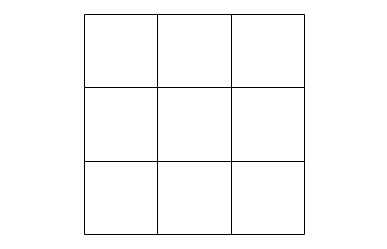

In [2]:
pn = op.network.Cubic([4, 4, 1])
fig, ax = plt.subplots(1, 1)
ax = op.topotools.plot_connections(network=pn, c='k', ax=ax)
plt.axis(False);

Label the pores on the left and right to indicate that the Network has two subdomains:

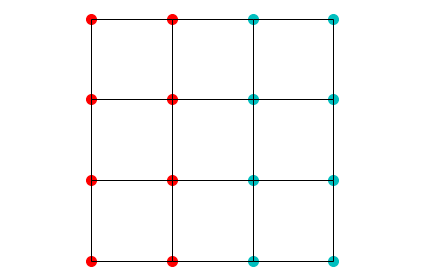

In [3]:
pn.set_label(label='layer1', pores=range(8))
pn.set_label(label='layer2', pores=range(8, 16))
op.topotools.plot_coordinates(network=pn, pores=pn.pores('layer1'), c='r', markersize=100, ax=ax)
op.topotools.plot_coordinates(network=pn, pores=pn.pores('layer2'), c='c', markersize=100, ax=ax)
fig  # Re-show figure

## The Preferred Way to Work with Subdomains

Create two Geometry objects, with one assigned to each set of pores (i.e. 'layer1' and 'layer2').  Let's also assign all the throats to ``geo1``. 

In [4]:
geo1 = op.geometry.GenericGeometry(network=pn, pores=pn.pores('layer1'), throats=pn.Ts)
geo2 = op.geometry.GenericGeometry(network=pn, pores=pn.pores('layer2'))
air = op.phases.Air(network=pn, name='air')

The "preferred" way to create Physics objects is to assign them to a specific Phase AND Geometry upon instantiation:

In [5]:
phys1 = op.physics.GenericPhysics(network=pn, phase=air, geometry=geo1)
phys2 = op.physics.GenericPhysics(network=pn, phase=air, geometry=geo2)

The ``project`` has a useful feature for studying the associations between Geometry, Phase, and Physics objects called the ``grid``. 

In [6]:
proj = pn.project
print(pn.project.grid)

+--------+---------+
| net_01 | air     |
+--------+---------+
| geo_01 | phys_01 |
| geo_02 | phys_02 |
+--------+---------+


When creating Physics objects as done above, all the associations between which pores and throats belong to each Physics is taken care of automatically. Essentially, all the pores/throats of ``geo1`` are assigned to ``phys1`` and simlarly all the pores/throats of ``geo2`` are assigned to ``phys2``. However, it is possible to make these assigments manually post-instantiation as will be demonstrated below, but first let's talk about how these associations are tracked by OpenPNM. When a Geometry object is created, two label arrays are added to the Network with ``True`` indicating the locations where that Geometry applies.  Let's see this by printing the Network:

In [7]:
print(pn)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.Cubic : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                      16 / 16   
2     throat.conns                                     24 / 24   
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      16        
2     pore.back                                     4         
3     pore.front                                    4         
4     pore.geo_01                                   8         
5     pore.geo_02                                   8 

As can be seen, there is a label array called 'pore.geo_01' that is ``True`` in 8 locations.  We can see which locations using ``np.where``:

In [8]:
print(np.where(pn['pore.geo_01'])[0])

[0 1 2 3 4 5 6 7]


And similarly, for ``geo2``:

In [9]:
print(np.where(pn['pore.geo_02'])[0])

[ 8  9 10 11 12 13 14 15]


These values are the locations in each array where ``True`` was found.  Note that they correspond to the pore locations used when creating ``geo1`` and ``geo2``.

> NOTE: We **cannot** just change the values in these arrays to change the locations where ``geo1`` and ``geo2`` are applied.  There are several things that need to go on behind the scenes.  For instance, if we want to transfer half the throats from ``geo1`` to ``geo2``, OpenPNM must also move any numerical data on ``geo1``, which requires resizes the arrays on both objects. *Instead we must use the ``set_locations`` method.*

## Working with Subdomains Manually

Let's recreate the above multidomain network to illustrate how to manually set locations and associations.

In [10]:
pn = op.network.Cubic([4, 4, 1])
pn.set_label(label='layer1', pores=range(8))
pn.set_label(label='layer2', pores=range(8, 16))
geo1 = op.geometry.GenericGeometry(network=pn, pores=pn.pores('layer1'))
geo2 = op.geometry.GenericGeometry(network=pn, pores=pn.pores('layer2'))
air = op.phases.Air(network=pn, name='air')

Next, create two Physics objects, but don't assign them to a Phase or a Geometry object.  Note that a warning is issued that the instantiation was not able to assign the Physics to any pores or throats.  We'll add these associations manually below:

In [11]:
phys1 = op.physics.GenericPhysics(network=pn)
phys2 = op.physics.GenericPhysics(network=pn)

------------------------------------------------------------
SOURCE     : openpnm.physics.GenericPhysics.__init__ 
TIME STAMP : 2021-10-24 19:22:51,263
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.physics.GenericPhysics.__init__ 
TIME STAMP : 2021-10-24 19:22:51,266
------------------------------------------------------------


Physics objects have a ``phase`` attribute that points to the Phase with which it is currently associated.  Because we did not provide one when initializing ``phys1`` and ``phys2`` this will raise an exception:

In [12]:
try:
    phys1.phase
except Exception as e:
    print(e)

Cannot find a phase associated with phys_01


We can assign a ``air`` to ``phys1`` as follows, after which we can retrieve it using the ``phase`` attribute:

In [13]:
phys1.phase = air
print(phys1.phase.name)

air


Physics objects also have ``geometry`` attribute which acts just like ``phase``.  We have not yet associated ``phys1`` with any locations so it will raise an error:

In [14]:
try:
    phys1.geometry
except Exception as e:
    print(e)

Cannot find a geometry associated with phys_01


We can assign a Geometry in the same manner as we did for Phase above.  This will connect ``phys1`` with the locations corresponding to ``geo1``:

In [15]:
phys1.geometry = geo1
print(phys1.geometry.name)
print(phys1.pores())

geo_01
[0 1 2 3 4 5 6 7]


In [16]:
phys1.Np

8

In [17]:
try:
    phys2.geometry = geo2
except Exception as e:
    print(e)

Cannot set locations for a physics object that is not associated with a phase


In [18]:
proj = pn.project
print(proj.grid)

+--------+---------+---------+
| net_01 | air     | ?       |
+--------+---------+---------+
| geo_01 | phys_01 | ---     |
| geo_02 | ---     | ---     |
| ?      | ---     | phys_02 |
| ---    | ---     | ---     |
+--------+---------+---------+


This shows that *phys_02* resides in the ? column indicating that it is not associated with a phase, and it resides in the ? row indicating it is not associated with a geometry either. Let's fix this below.

In [19]:
phys2.phase = air
phys2.geometry = geo2

In [20]:
print(pn.project.grid)

+--------+---------+
| net_01 | air     |
+--------+---------+
| geo_01 | phys_01 |
| geo_02 | phys_02 |
| ---    | ---     |
+--------+---------+


Now we can see that *phys_02* is associated with *geo_02* and *air*.  We can also see there are some locations, either pores or throats, that are not yet associated with a geometry object, as indicated by *---* in the first column.  This is because we did not assign any throats to a Geometry yet.  Let's fix this below:

In [21]:
geo3 = op.geometry.GenericGeometry(network=pn, throats=range(12))

In [22]:
print(pn.project.grid)

+--------+---------+
| net_01 | air     |
+--------+---------+
| geo_01 | phys_01 |
| geo_02 | phys_02 |
| geo_03 | ---     |
| ---    | ---     |
+--------+---------+


Note that we only assigned 12 throats to ``geo3``, but there were 24 throats in the network. We can either create yet another Geometry, or we can use the ``set_locations`` method:

In [23]:
geo3.set_locations(throats=range(12, 24))

In [24]:
print(pn.project.grid)

+--------+---------+
| net_01 | air     |
+--------+---------+
| geo_01 | phys_01 |
| geo_02 | phys_02 |
| geo_03 | ---     |
+--------+---------+


Now we can see that all locations are assigned to a Geometry, indicated by the lack of any rows in the first column containing *---*.  We still need to create a Physics object for these throats.  

Again, let's not assign it to the throats during instantiation and do it manually afterward. But we will include a Phase:

In [25]:
phys3 = op.physics.GenericPhysics(network=pn, phase=air)

------------------------------------------------------------
SOURCE     : openpnm.physics.GenericPhysics.__init__ 
TIME STAMP : 2021-10-24 19:22:51,560
------------------------------------------------------------


In [26]:
print(pn.project.grid)

+--------+---------+
| net_01 | air     |
+--------+---------+
| geo_01 | phys_01 |
| geo_02 | phys_02 |
| geo_03 | ---     |
| ?      | phys_03 |
+--------+---------+


Because we included a Phase, this new Physics is in the appropriate column, but is in a *?* row since it is not yet associated with a Geometry. Instead of using the ``geometry`` attribute as we did above, let's use the ``set_geometry`` method, which is actually called behind the scenes when using the ``geometry`` attribute:

In [27]:
phys3.set_geometry(geo3)

Now we can print the project's grid and see that everything is looking good:

In [28]:
print(pn.project.grid)

+--------+---------+
| net_01 | air     |
+--------+---------+
| geo_01 | phys_01 |
| geo_02 | phys_02 |
| geo_03 | phys_03 |
+--------+---------+
